In [126]:
import os
import sys
import flopy as fp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyemu
from shutil import copyfile
plt.rcParams['font.size']=12

In [127]:
workspace = "workspace"
model_name = "mf6model"
exe_name="mf6.exe"

nrow = 280
ncol = 240

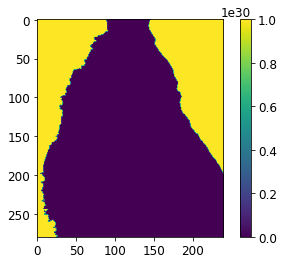

In [128]:
plt.imshow(fp.utils.HeadFile("workspace/{}.hds".format(model_name)).get_data((0,0))[0])
plt.colorbar()

In [129]:
sim = fp.mf6.MFSimulation.load(sim_ws=workspace)
m = sim.get_model(model_name)
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(workspace, "{}.nam".format(model_name)),
        delr=m.dis.delr.array, delc=m.dis.delc.array)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package riv...
    loading package obs...
    loading package oc...
  loading ims package mf6model...
   could not remove start_datetime


In [130]:
#sr=pyemu.utils.helpers.SpatialReference.set_spatialreference(xul=None, yul=None, xll=None, yll=None, rotation=0.0)

In [131]:
xul, yul = 1098000, 1285000 # Model Origin

dxdy = 50 #grid spacing
delc = np.ones(nrow, dtype=float) * dxdy
delr = np.ones(ncol, dtype=float) * dxdy
rot = 0

sr = pyemu.helpers.SpatialReference(delr=delr, delc=delc, xul=xul, yul=yul, rotation=rot, epsg='3116')
sr

xul:1098000; yul:1285000; rotation:0; proj4_str:+init=epsg:3116; units:meters; lenuni:2; length_multiplier:1.0

In [132]:
file = "heads.csv"
fileout = "workspace/heads.csv"
os.remove(fileout)
copyfile(file, fileout) # copy 

# empty pst from object
template_ws = "template"
pf = pyemu.utils.PstFrom(original_d=workspace, new_d=template_ws,
                 remove_existing=True,
                 longnames=True, spatial_reference=sr,
                 zero_based=False)

2021-02-20 14:23:00.247075 starting: opening PstFrom.log for logging
2021-02-20 14:23:00.248076 starting PstFrom process
2021-02-20 14:23:00.249077 starting: setting up dirs
2021-02-20 14:23:00.250076 starting: removing existing new_d 'template'
2021-02-20 14:23:00.291358 finished: removing existing new_d 'template' took: 0:00:00.041282
2021-02-20 14:23:00.291358 starting: copying original_d 'workspace' to new_d 'template'
2021-02-20 14:23:00.347372 finished: copying original_d 'workspace' to new_d 'template' took: 0:00:00.056014
2021-02-20 14:23:00.348370 finished: setting up dirs took: 0:00:00.099293


In [133]:
#add observation
df = pd.read_csv(os.path.join(template_ws,"heads.csv"),index_col=0)

hds_df = pf.add_observations("heads.csv",insfile="heads.csv.ins",index_cols="time",
                use_cols=list(df.columns.values),prefix="hds",obsgp=False)

case = "pest_test"
pf.build_pst("{}.pst".format(case))

2021-02-20 14:23:00.802593 starting: adding observations from tabular output file
2021-02-20 14:23:00.803594 starting: reading list template\heads.csv
2021-02-20 14:23:00.805594 finished: reading list template\heads.csv took: 0:00:00.002000
2021-02-20 14:23:00.806595 starting: building insfile for tabular output file heads.csv
2021-02-20 14:23:00.813596 finished: building insfile for tabular output file heads.csv took: 0:00:00.007001
2021-02-20 14:23:00.813596 starting: adding observation from instruction file 'template\heads.csv.ins'
2021-02-20 14:23:00.819600 finished: adding observation from instruction file 'template\heads.csv.ins' took: 0:00:00.006004
2021-02-20 14:23:00.820598 finished: adding observations from tabular output file took: 0:00:00.018005
noptmax:30, npar_adj:0, nnz_obs:33


spatial variogram


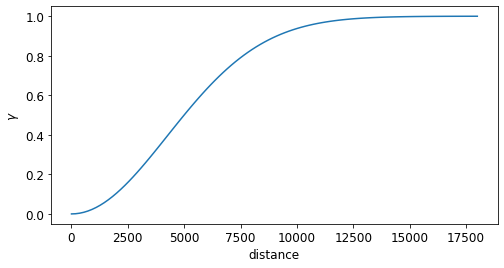

In [134]:
ppspace1=30
a = ppspace1*4.0*50
v = pyemu.geostats.GauVario(contribution=1.0,a=a)
grid_gs1 = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs1.plot()
print("spatial variogram")

spatial variogram


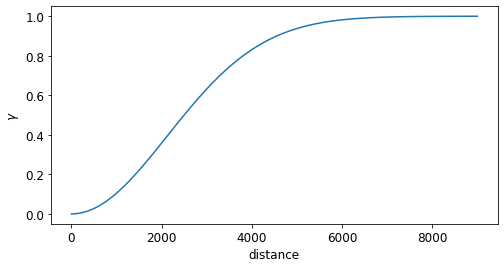

In [135]:
ppspace2=15
a = ppspace2*4.0*50
v = pyemu.geostats.GauVario(contribution=1.0,a=a)
grid_gs2 = pyemu.geostats.GeoStruct(variograms=v, transform='log')

fig = plt.figure(figsize=(8,4))
grid_gs2.plot()
print("spatial variogram")

In [136]:
# set an homogeneous k array (as initial value)
# k = 1e-4*np.ones([nrow,ncol])
# filnm = "k.txt"
# np.savetxt(os.path.join(template_ws,filnm),k)

In [137]:
# Model domain in txt file because the code for some reason is not respecting my m.dis.idomain in the pilot point section
# maxsize to check these matrices very well!
np.set_printoptions(threshold=sys.maxsize)

ib0=np.loadtxt(os.path.join(workspace,"mf6model.dis_idomain_layer0.txt"))
ib1=np.loadtxt(os.path.join(workspace,"mf6model.dis_idomain_layer1.txt"))
ib2=np.loadtxt(os.path.join(workspace,"mf6model.dis_idomain_layer2.txt"))
ib3=np.loadtxt(os.path.join(workspace,"mf6model.dis_idomain_layer3.txt"))

ib=[ib0,ib1,ib2,ib3]

# To make sure only greater than zero values are being considered in the pilot point automated placement for all layers
nlay=4
for i in range(0,nlay):
    ib[i][ib[i]==-1]=0

In [138]:
#Horizontal conductivity for the 4 layers
#layer1
"""
pf.add_parameters(filenames="hk0.txt",par_type="constant",
                   par_name_base="kp0",pargp="hp1", zone_array=ib[0], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1, ult_ubound=1.1921e-3,ult_lbound=1.1574e-8)
"""
#layer2
pf.add_parameters(filenames="hk1.txt",par_type="pilotpoint",pp_space=ppspace2,
                   par_name_base="kp1",pargp="hp2", zone_array=ib[1], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs2, ult_ubound=1.1921e-3,ult_lbound=1.1921e-5)
#layer3
pf.add_parameters(filenames="hk2.txt",par_type="pilotpoint",pp_space=ppspace2,
                   par_name_base="kp2",pargp="hp3", zone_array=ib[2], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs2, ult_ubound=1.1574e-6,ult_lbound=1.1574e-8)

#layer4
pf.add_parameters(filenames="hk3.txt",par_type="pilotpoint",pp_space=ppspace1,
                   par_name_base="kp3",pargp="hp4", zone_array=ib[3], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs1, ult_ubound=4.167e-4,ult_lbound=4.167e-6)

#Vertical conductivity for the 4 layers
#layer1
"""
pf.add_parameters(filenames="vk0.txt",par_type="constant",
                  par_name_base="kp0",pargp="vp1", zone_array=ib[0], spatial_reference=sr,
                  upper_bound=10.,lower_bound=0.1, ult_ubound=2.1991e-4,ult_lbound=1.0417e-8)
"""
#layer2
pf.add_parameters(filenames="vk1.txt",par_type="pilotpoint",pp_space=ppspace2,
                  par_name_base="kp1",pargp="vp2", zone_array=ib[1], spatial_reference=sr,
                  upper_bound=10.,lower_bound=0.1,geostruct=grid_gs2, ult_ubound=2.1991e-4,ult_lbound=2.1991e-6)
#layer3
pf.add_parameters(filenames="vk2.txt",par_type="pilotpoint",pp_space=ppspace2,
                   par_name_base="kp2",pargp="vp3", zone_array=ib[2], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs2, ult_ubound=1.0417e-6,ult_lbound=1.0417e-8)
#layer4
pf.add_parameters(filenames="vk3.txt",par_type="pilotpoint",pp_space=ppspace1,
                   par_name_base="kp3",pargp="vp4", zone_array=ib[3], spatial_reference=sr,
                   upper_bound=10.,lower_bound=0.1,geostruct=grid_gs1, ult_ubound=1.736e-5,ult_lbound=1.736e-7)



2021-02-20 14:23:03.770471 starting: adding pilotpoint type multiplier style parameters for file(s) ['hk1.txt']
2021-02-20 14:23:03.770471 starting: loading array template\hk1.txt
2021-02-20 14:23:03.834990 finished: loading array template\hk1.txt took: 0:00:00.064519
2021-02-20 14:23:03.834990 loaded array 'hk1.txt' of shape (280, 240)
2021-02-20 14:23:03.895003 starting: writing array-based template file 'kp1_inst0_pilotpoint.csv.tpl'
2021-02-20 14:23:03.895003 starting: setting up pilot point parameters
2021-02-20 14:23:03.959017 37 pilot point parameters created
2021-02-20 14:23:03.959017 pilot point 'pargp':kp1_inst:0
2021-02-20 14:23:03.959017 finished: setting up pilot point parameters took: 0:00:00.064014
2021-02-20 14:23:03.966019 starting: calculating factors for pargp=kp1_inst:0
2021-02-20 14:23:03.966019 saving krige variance file:template\kp1_inst0pp.var.dat
2021-02-20 14:23:03.966019 saving krige factors file:template\kp1_inst0pp.fac
starting interp point loop for 67200 p

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


took 32.317928 seconds
2021-02-20 14:23:36.700040 finished: calculating factors for pargp=kp1_inst:0 took: 0:00:32.734021
2021-02-20 14:23:36.701148 starting: writing array-based template file 'kp1_inst0pp.dat.tpl'
2021-02-20 14:23:36.705544 finished: adding pilotpoint type multiplier style parameters for file(s) ['hk1.txt'] took: 0:00:32.935073
2021-02-20 14:23:36.716547 starting: adding pilotpoint type multiplier style parameters for file(s) ['hk2.txt']
2021-02-20 14:23:36.717546 starting: loading array template\hk2.txt
2021-02-20 14:23:36.777560 finished: loading array template\hk2.txt took: 0:00:00.060014
2021-02-20 14:23:36.777560 loaded array 'hk2.txt' of shape (280, 240)
2021-02-20 14:23:36.837574 starting: writing array-based template file 'kp2_inst0_pilotpoint.csv.tpl'
2021-02-20 14:23:36.837574 starting: setting up pilot point parameters
2021-02-20 14:23:36.901587 37 pilot point parameters created
2021-02-20 14:23:36.901587 pilot point 'pargp':kp2_inst:0
2021-02-20 14:23:36.9

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


took 48.642122 seconds
2021-02-20 14:24:27.884158 finished: calculating factors for pargp=kp3_inst:0 took: 0:00:50.762521
2021-02-20 14:24:27.884158 starting: writing array-based template file 'kp3_inst0pp.dat.tpl'
2021-02-20 14:24:27.890159 finished: adding pilotpoint type multiplier style parameters for file(s) ['hk3.txt'] took: 0:00:50.975569
2021-02-20 14:24:27.934169 starting: adding pilotpoint type multiplier style parameters for file(s) ['vk1.txt']
2021-02-20 14:24:27.935169 starting: loading array template\vk1.txt
2021-02-20 14:24:27.995183 finished: loading array template\vk1.txt took: 0:00:00.060014
2021-02-20 14:24:27.996183 loaded array 'vk1.txt' of shape (280, 240)
2021-02-20 14:24:28.054196 starting: writing array-based template file 'kp1_inst1_pilotpoint.csv.tpl'
2021-02-20 14:24:28.055196 starting: setting up pilot point parameters
2021-02-20 14:24:28.125259 37 pilot point parameters created
2021-02-20 14:24:28.126259 pilot point 'pargp':kp1_inst:1
2021-02-20 14:24:28.1

In [139]:
# add run model command
pf.mod_sys_cmds.append("..\mf6")
pf.build_pst("{}.pst".format(case))

noptmax:30, npar_adj:244, nnz_obs:33
2021-02-20 14:24:28.691125 forward_run line:pyemu.os_utils.run(r'..\mf6')



In [140]:
#Rewrite ins file because Pyemu isn't smart enough

file = "template/heads.csv.ins"
fileout = "template/heads2.csv.ins"
with open(file) as f:
    with open(fileout,"w") as fout:
        for i,line in enumerate(f):
            if i < 2:
                fout.write(line)
            if i > 1:
                for o,split in enumerate(line.split("w")):
                    if o == 1:
                        fout.write("~,~")
                    fout.write(split)
                        

copyfile(fileout, file) # copy 
os.remove(fileout) # delete tmp file

noptmax:30, npar_adj:244, nnz_obs:33
2021-02-20 14:24:28.838158 WARNING: sys_cmd 'pyemu.os_utils.run(r'..\mf6')
' already in sys cmds, skipping...
2021-02-20 14:24:28.850161 starting: building prior covariance matrix
2021-02-20 14:24:28.892169 saving prior covariance matrix to file template\pest_test.prior.cov
2021-02-20 14:24:28.924177 finished: building prior covariance matrix took: 0:00:00.074016


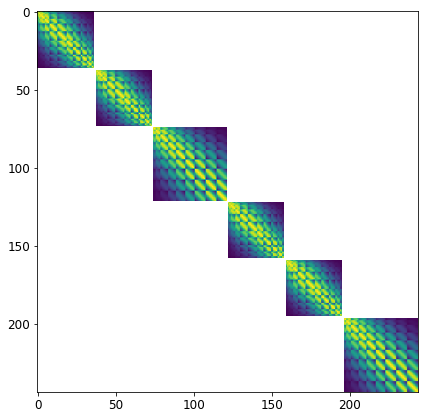

In [141]:
pst = pf.build_pst("{}.pst".format(case))
cov = pf.build_prior()
x = cov.x.copy()
x[x==0.0] = np.NaN
fig,ax = plt.subplots(1,1,figsize=(7,7))
g = ax.imshow(x)

In [142]:
t_d = "template"
m_d = "master_glm"

pst.control_data.noptmax = 0 # just a run
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:0, npar_adj:244, nnz_obs:33


In [144]:
# calculate
n = 12 #select number of workers
pyemu.os_utils.start_workers(t_d,"../pestpp-glm.exe","{}.pst".format(case),num_workers=n,worker_root=".",master_dir=m_d)

In [145]:
pst.control_data.noptmax = -1 # FOR JACOBIAN
pst.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.start_workers(t_d,"../pestpp-glm.exe","{}.pst".format(case),num_workers=n,worker_root=".",master_dir=m_d)

noptmax:-1, npar_adj:244, nnz_obs:33


In [146]:
t_d ="master_glm"
case="pest_test"
pst = pyemu.Pst(os.path.join(t_d,"{}.pst".format(case)))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
kp1_inst:0,kp1_inst:0,log,37,0,1,-1,0.5
kp1_inst:1,kp1_inst:1,log,37,0,1,-1,0.5
kp2_inst:0,kp2_inst:0,log,37,0,1,-1,0.5
kp2_inst:1,kp2_inst:1,log,37,0,1,-1,0.5
kp3_inst:0,kp3_inst:0,log,48,0,1,-1,0.5
kp3_inst:1,kp3_inst:1,log,48,0,1,-1,0.5


In [147]:
pst.control_data.noptmax = 2
pst.control_data.pestmode = "regularization"

pst.pestpp_options["n_iter_base"] = 1 
pst.pestpp_options["n_iter_super"] = 4 
# pst.pestpp_options["glm_num_reals"] = 300 
#
pst.pestpp_options["parcov"] = "{}.prior.cov".format(case) 
pst.pestpp_options["base_jacobian"] = "{}.jcb".format(case) 
pst.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.helpers.zero_order_tikhonov(pst)

noptmax:2, npar_adj:244, nnz_obs:33


In [148]:
m_d = "master_glm_run"
pyemu.os_utils.start_workers(t_d,"../pestpp-glm","{}.pst".format(case),num_workers=n,worker_root=".",
                           master_dir=m_d)

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

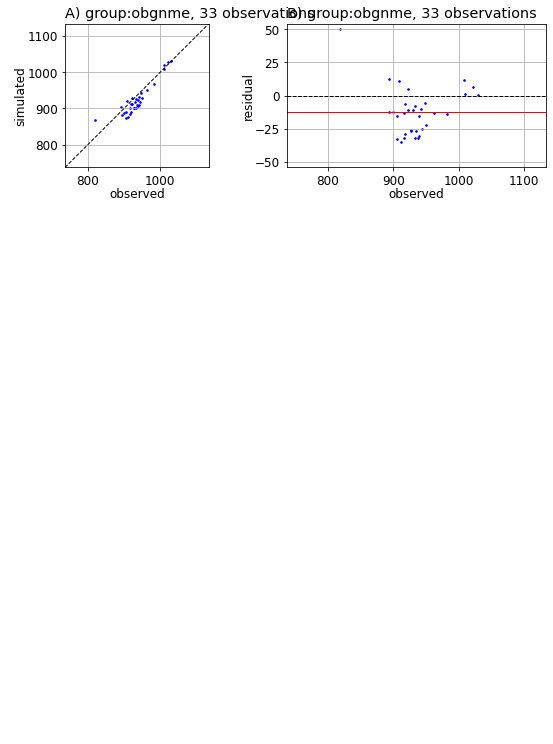

In [149]:
pst_a = pyemu.Pst(os.path.join(m_d,"{}.pst".format(case)))
pst_a.plot(kind='1to1')

In [ ]:
df = df=pd.read_csv(os.path.join(m_d,"{}.post.obsen.csv".format(case)),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)
ax = oe.phi_vector.hist()

In [150]:
dfp = df=pd.read_csv(os.path.join(m_d,"{}.par.usum.csv".format(case)),index_col=0)
10**dfp["post_mean"]

name
KP1_INST:0_I:67_J:127     10.000000
KP1_INST:0_I:67_J:157     10.000000
KP1_INST:0_I:82_J:142     10.000000
KP1_INST:0_I:82_J:157     10.000000
KP1_INST:0_I:82_J:172     10.000000
                            ...    
KP3_INST:1_I:255_J:75     10.000000
KP3_INST:1_I:255_J:105     6.577790
KP3_INST:1_I:255_J:135     0.100000
KP3_INST:1_I:255_J:165     0.100000
KP3_INST:1_I:255_J:195     0.889577
Name: post_mean, Length: 244, dtype: float64

In [ ]:
plt.hist(10**dfp["post_mean"],bins=30)

In [151]:
pst.parameter_data.parval1 = 10**dfp["post_mean"].values
pst.control_data.noptmax = 0 # one run with optimal parameters

pst.write(os.path.join(t_d,"{}.pst".format(case)))

pyemu.os_utils.run("..\pestpp-glm.exe {}".format(case),cwd=t_d)

noptmax:0, npar_adj:244, nnz_obs:33


Text(0.5, 1.0, 'k after inversion')

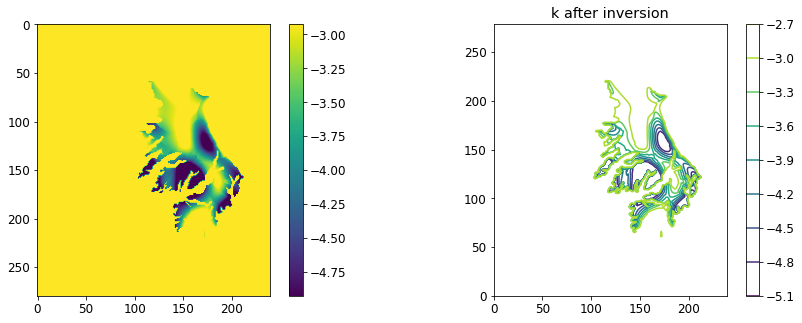

In [154]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

# inversion
g= ax[0].imshow(np.log10(np.loadtxt(os.path.join(t_d,"hk1.txt"))))
plt.colorbar(g,ax=ax[0])
plt.title("k after inversion")

a=ax[1].contour(np.flipud(np.log10(np.loadtxt(os.path.join(t_d,"hk1.txt")))))
ax[1].set_aspect("equal")
plt.colorbar(a,ax=ax[1])
plt.title("k after inversion")

Text(0.5, 1.0, 'k before inversion')

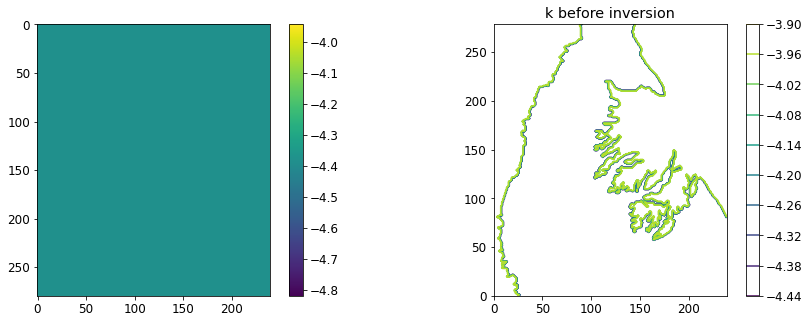

In [99]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

# inversion
g= ax[0].imshow(np.log10(np.loadtxt(os.path.join("workspace","hk3.txt"))))
plt.colorbar(g,ax=ax[0])
plt.title("k before inversion")

a=ax[1].contour(np.flipud(np.log10(np.loadtxt(os.path.join("workspace","hk0.txt")))))
ax[1].set_aspect("equal")
plt.colorbar(a,ax=ax[1])
plt.title("k before inversion")

In [ ]:
pst_a.plot()